In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import *

from matplotlib import rc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

In [2]:
scale = 1
fontsize_pt = 11*scale # 11.74983
fontsize_pt = 10*scale # 11.74983
textwidth_pt = 412.56497*scale

# https://gist.github.com/martijnvermaat/b5fe45124049b1e8e037

def configure(document_fontsize=fontsize_pt, available_width=textwidth_pt):
    """
    Configures Matplotlib so saved figures can be used in LaTeX documents.
    Uses the sans-serif TeX Gyre Heros font (Helvetica), also for math.
    Arguments:
    - document_fontsize: Font size in points (use "\the\fontdimen6\font" in
      your LaTeX document to get the current value). The default is for a
      LaTeX Beamer document at 14pt ("\documentclass[14pt]{beamer}") which
      for some reason is slightly more than 14pt.
    - available_width: The available width in your LaTeX document, usually
      the value of "\textwidth". The default is for a LaTeX Beamer document
      with the default theme.
    Returns a function that calculates figure size given a fraction of the
    available width for the figure to occupy.
    Figures can be saved as PDF:
        fig.tight_layout(pad=0.1)
        fig.savefig('figure.pdf')
    And included in your document as follows:
        \begin{frame}
          \begin{center}
            \includegraphics[width=1.0\textwidth,transparent]{figure.pdf}
          \end{center}
        \end{frame}
    Todo:
    - Make font family and face configurable.
    - Example IPython Notebook and LaTeX document.
    - Document dependencies (tex-gyre, dvipng, ...).
    Based on: http://damon-is-a-geek.com/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib.html
    """
    def figsize(width_fraction=1.0):
        """
        width_fraction: The fraction of the available width you'd like the figure to occupy.
        """
        width_pt = available_width * width_fraction

        inches_per_pt = 1.0 / 72.27
        golden_ratio  = (5**0.5 - 1.0) / 2.0

        width_in = width_pt * inches_per_pt
        height_in = width_in * golden_ratio
        return width_in, height_in
    
    from matplotlib import rcParams
    #rcParams['figure.dpi']=160    
    rcParams['font.size'] = document_fontsize
    rcParams['axes.titlesize'] = document_fontsize
    rcParams['axes.labelsize'] = document_fontsize
    rcParams['xtick.labelsize'] = document_fontsize
    rcParams['ytick.labelsize'] = document_fontsize
    rcParams['legend.fontsize'] = document_fontsize
    #rcParams['font.family'] = 'sans-serif'
    #rcParams['font.sans-serif'] = ['tgheros']
    #rcParams['font.serif'] = ['cm10']
    rcParams['text.usetex'] = True
    rcParams['text.latex.preamble'] = r"""
        \usepackage[T1]{fontenc}
        \usepackage{amsmath}
        \usepackage{amsfonts}
        \usepackage{amssymb}
        \DeclareMathOperator*{\argmax}{arg\,max}
        \DeclareMathOperator*{\argmin}{arg\,min}
        \DeclareMathOperator*{\Dklsym}{D_{\mathrm{KL}}}
        \newcommand{\Dkl}[2]{\Dklsym\left(#1\;\middle\|\;#2\right)}
        """
    rcParams['figure.figsize'] = figsize()

    return figsize
figsize = configure()

## Homoscedastic and heteroscedastic noise

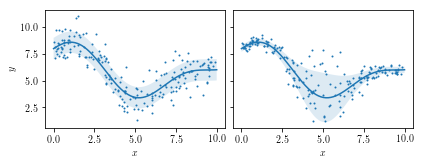

In [3]:
x = np.linspace(0, 10, num=200)
f = lambda x: sin(x)+2*cos(x/2)+6
e = lambda x: 2*exp(-(x-5)**2/3)+0.3
y = np.array([f(x) for x in x])
ye = np.array([e(x) for x in x])

x_samples = np.random.rand(200)*10
y_samples = np.array([f(x) for x in x_samples])
ye_heterosced_samples = np.array([f(x)+np.random.randn()*e(x) for x in x_samples])
ye_homosced_samples = np.array([f(x)+np.random.randn() for x in x_samples])

w, h = figsize()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(w,h*0.6))

ax1.fill_between(x, y-1, y+1, facecolor='C0', alpha=0.15, lw=0, interpolate=False)
ax1.plot(x, y, color='C0')
ax1.scatter(x_samples, ye_homosced_samples, s=1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax2.fill_between(x, y-ye, y+ye, facecolor='C0', alpha=0.15, lw=0, interpolate=False)
ax2.plot(x, y, color='C0')
ax2.scatter(x_samples, ye_heterosced_samples, s=1)
ax2.set_xlabel('$x$')

fig.tight_layout(pad=0.1)

# \includegraphics[width=1.0\textwidth,transpaent]{figure.pdf}

In [4]:
fig.savefig('../data/plots/homoscedastic-heteroscedastic-noises.pdf')

## KL-divergence asymmetry and minimization

1 0.019831667 1.352676e-05 2.7182817 [2.5808293e-15 2.7957521e-15 3.0282667e-15 3.2797942e-15 3.5518537e-15]
2 0.025193091 -1.9999897 1.0 [2.5808293e-15 2.7957521e-15 3.0282667e-15 3.2797942e-15 3.5518537e-15]
1 0.019535435 0.20000014 2.8775592 [1.3072624e-13 1.4046473e-13 1.5091433e-13 1.6212612e-13 1.7415381e-13]
2 0.025122037 -1.971312 1.0414004 [1.3072624e-13 1.4046473e-13 1.5091433e-13 1.6212612e-13 1.7415381e-13]
1 0.019535435 0.20000014 2.8775098 [1.2117633e-13 1.3022107e-13 1.3993053e-13 1.5034678e-13 1.6152464e-13]
2 0.025121985 -1.9710681 1.0404453 [1.2117633e-13 1.3022107e-13 1.3993053e-13 1.5034678e-13 1.6152464e-13]
1 0.019535398 0.20000014 2.8766103 [1.1563135e-13 1.2427411e-13 1.3355049e-13 1.4350591e-13 1.5418875e-13]
2 0.02512199 -1.9709123 1.0398597 [1.1563135e-13 1.2427411e-13 1.3355049e-13 1.4350591e-13 1.5418875e-13]
1 0.019535366 0.20000014 2.8752716 [1.12939335e-13 1.21386842e-13 1.30453428e-13 1.40184143e-13
 1.50626324e-13]
2 0.025122 -1.9708284 1.0395663 [1.12

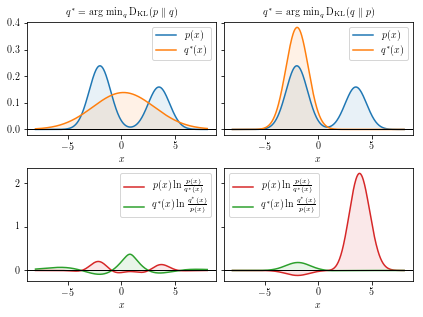

In [30]:
def klam():
    normal = lambda m, s: (lambda x: 1/((2*np.pi)**0.5*s)*torch.exp(-(x-m)**2/(2*s**2)))
    
    # fixed distribution
    p = lambda x: 0.6*normal(-2.0, 1)(x) + 0.4*normal(3.5, 1)(x)
    
    # variable approximating distribution
    params1 = [torch.tensor(v, requires_grad=True) for v in [0.0, 1.0]]
    m1, logs1 = params1
    
    params2 = [torch.tensor(v, requires_grad=True) for v in [-2.0, 0.0]]
    m2, logs2 = params2
    
    params = params1 + params2

    # KL-divergence sub-integral function
    dkl_sub = lambda p, q: (lambda x: p(x)*torch.log(p(x)/q(x)))
    
    lr = 1e-2
    optimizer = optim.SGD(params, lr=lr, momentum=0.9)
    
    iter_count = 20000
    for i in range(iter_count):
        #xs = torch.rand(1000)*20-10
        xs = torch.linspace(-10, 10, steps=2000)
          
        s1 = torch.exp(logs1)
        s2 = torch.exp(logs2)
        q1 = normal(m1, s1)
        q2 = normal(m2, s2)
    
        losses_pq = dkl_sub(p, q1)(xs)
        losses_qp = dkl_sub(q2, p)(xs)
        loss1 = losses_pq.mean()
        loss2 = losses_qp.mean()
        loss = loss1 + loss2

        loss.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(params, 1e-3/(i+1)**0.5/lr)
        for v in params:
            v.grad.data[v.grad.data!=v.grad.data] = 0
            #v.data.add_(-lr, v.grad.data)
        optimizer.step()
        
        if i % (iter_count//5) == 0:
            print(1, loss1.detach().numpy(), m1.detach().numpy(), s1.detach().numpy(), losses_qp.detach().numpy()[:5])
            print(2, loss2.detach().numpy(), m2.detach().numpy(), s2.detach().numpy(), losses_qp.detach().numpy()[:5])
    
    # Plotting

    x = torch.linspace(-8, 8, steps=400)
    yp = torch.stack(list(map(p, x)))
    yq1 = torch.stack(list(map(q1, x)))
    yq2 = torch.stack(list(map(q2, x)))

    dkl_subqp1 = dkl_sub(q1,p)(x).detach().numpy()
    dkl_subpq1 = dkl_sub(p,q1)(x).detach().numpy()

    dkl_subqp2 = dkl_sub(q2,p)(x).detach().numpy()
    dkl_subpq2 = dkl_sub(p,q2)(x).detach().numpy()

    x = x.numpy()

    w, h = figsize()

    def plot_distribution(ax, x, y, color, label='$y$'):
        ax.fill_between(x, 0, y, facecolor=color, alpha=0.1, lw=0, interpolate=False)
        ax.plot(x, y, color=color, label=label)
        ax.set_xlabel('$x$')

    fig, axes = plt.subplots(2, 2, sharey='row', figsize=(w, h*0.6*2))
    plot_distribution(axes[0,0], x, yp.detach().numpy(), 'C0', r'$p(x)$')
    plot_distribution(axes[0,0], x, yq1.detach().numpy(), 'C1', r'$q^*(x)$')
    axes[0,0].legend()
    axes[0,0].set_title(r'$q^*=\argmin_q \Dkl{p}{q}$')
    axes[0,0].axhline(linewidth=1, color='k')
    plot_distribution(axes[0,1], x, yp.detach().numpy(), 'C0', r'$p(x)$')
    plot_distribution(axes[0,1], x, yq2.detach().numpy(), 'C1', r'$q^*(x)$')
    axes[0,1].legend()
    axes[0,1].set_title(r'$q^*=\argmin_q \Dkl{q}{p}$')
    axes[0,1].axhline(linewidth=1, color='k')
    plot_distribution(axes[1,0], x, dkl_subpq1, 'C3', r'$p(x)\ln\frac{p(x)}{q^*(x)}$')
    plot_distribution(axes[1,0], x, dkl_subqp1, 'C2', r'$q^*(x)\ln\frac{q^*(x)}{p(x)}$')
    axes[1,0].legend()
    axes[1,0].axhline(linewidth=1, color='k')
    plot_distribution(axes[1,1], x, dkl_subpq2, 'C3', r'$p(x)\ln\frac{p(x)}{q^*(x)}$') 
    plot_distribution(axes[1,1], x, dkl_subqp2, 'C2', r'$q^*(x)\ln\frac{q^*(x)}{p(x)}$')
    axes[1,1].legend()
    axes[1,1].axhline(linewidth=1, color='k')
    fig.tight_layout(pad=0.1)
    return fig

fig = klam()

In [31]:
fig.savefig('../data/plots/dkl-asymmetry.pdf')